In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

In [9]:
image_path_train = "IndustryBiscuitLotus/TRAIN"
image_path_ok = "IndustryBiscuitLotus/OK"
image_path_nok = "IndustryBiscuitLotus/NOK"

In [10]:
image_path_train = "marble/train/good"
image_path_ok = "marble/test/good"
image_path_nok = "marble/test/crack/"

In [11]:
IMAGE_SIZE = 64  # Resize images to 64x64
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is {DEVICE}.")

The device is cpu.


In [12]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 16 -> 8
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # 32 -> 64
            nn.Sigmoid(),  # output in [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])


In [14]:
from torchvision.io import read_image

class CookieImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.image_names = os.listdir(self.img_dir)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_names[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [15]:
train_dataset = CookieImageDataset(image_path_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [16]:
model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs in train_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/20], Loss: 0.0149
Epoch [2/20], Loss: 0.0040
Epoch [3/20], Loss: 0.0015
Epoch [4/20], Loss: 0.0007
Epoch [5/20], Loss: 0.0005
Epoch [6/20], Loss: 0.0004
Epoch [7/20], Loss: 0.0004
Epoch [8/20], Loss: 0.0003
Epoch [9/20], Loss: 0.0004
Epoch [10/20], Loss: 0.0003
Epoch [11/20], Loss: 0.0003
Epoch [12/20], Loss: 0.0003
Epoch [13/20], Loss: 0.0003
Epoch [14/20], Loss: 0.0003
Epoch [15/20], Loss: 0.0003
Epoch [16/20], Loss: 0.0003
Epoch [17/20], Loss: 0.0003
Epoch [18/20], Loss: 0.0003
Epoch [19/20], Loss: 0.0003
Epoch [20/20], Loss: 0.0002


In [17]:
def compare_orig_and_reconstructed(orig, recon):
    # Optional: visualize
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(np.transpose(orig[0], (1, 2, 0)))
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed")
    plt.imshow(np.transpose(recon[0], (1, 2, 0)))
    plt.show()

In [18]:
def compute_reconstruction_error(img_path):
    img = Image.open(img_path)
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(img_tensor)
    loss = criterion(output, img_tensor).item()
    return loss, img_tensor.cpu(), output.cpu()


Reconstruction error: 0.0004


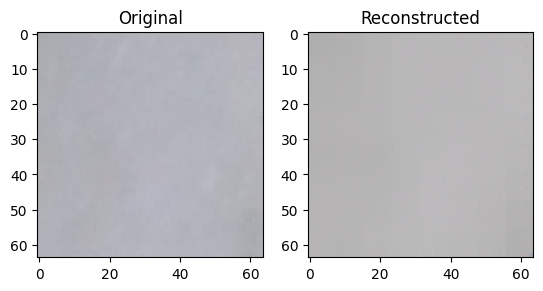

Reconstruction error: 0.0381


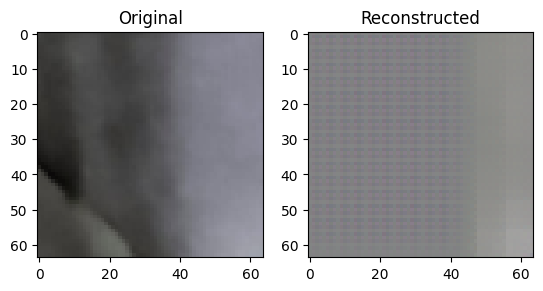

Reconstruction error: 0.0011


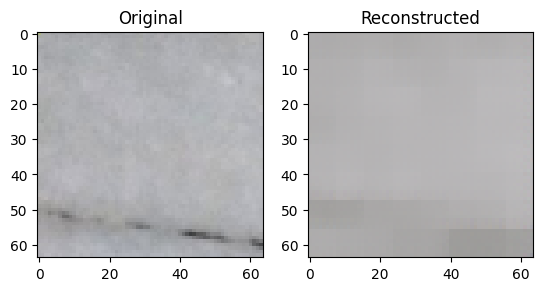

Reconstruction error: 0.0004


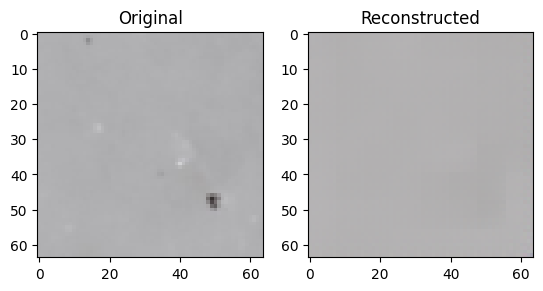

In [20]:
# Example
error, orig, recon = compute_reconstruction_error("marble/test/good/_0_0_20210525_15434.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon)

error, orig, recon = compute_reconstruction_error("marble/test/crack/_0_0_20210531_17292_0.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon)

error, orig, recon = compute_reconstruction_error("marble/test/joint/_0_4352_20210525_15441_1.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon)

error, orig, recon = compute_reconstruction_error("marble/test/dot/_0_2560_20210531_10521_2.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon)

In [25]:
from numpy import mean


def compute_mean_reconstruction_error(image_path):
    recon_errors = []
    for file_name in os.listdir(image_path):
        error, _, _ = compute_reconstruction_error(os.path.join(image_path, file_name))
        recon_errors.append(error)
    return mean(recon_errors), min(recon_errors), max(recon_errors)

In [26]:
print(compute_mean_reconstruction_error("marble/test/good"))
print(compute_mean_reconstruction_error("marble/test/crack"))
print(compute_mean_reconstruction_error("marble/test/joint"))
print(compute_mean_reconstruction_error("marble/test/dot"))

(np.float64(0.0003034554515419158), 0.00012126961519243196, 0.004400694277137518)
(np.float64(0.0059685296086453435), 0.00018834015645552427, 0.07511729747056961)
(np.float64(0.0023756092479556967), 0.00018052698578685522, 0.019471071660518646)
(np.float64(0.0018922583343131312), 0.00026709213852882385, 0.009411083534359932)
